Restarted clima (Python 3.12.12)

In [ ]:
import numpy as np
import xarray as xr
import dask.array as da
import os,glob,sys
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm
import matplotlib.ticker as mticker 
from matplotlib.ticker import LogLocator, AutoMinorLocator
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
import matplotlib.patheffects as pe
from scipy.ndimage import gaussian_filter
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import pandas as pd
from typing import Tuple, Dict, Optional
from scipy import stats
import rasterio
from pathlib import Path

"""
This is an introduction to the high wind speeds, as such, the first plot is the distribution of
the full timeseries of wind speeds for each model. 

Code to compute and map the spatial statitistics of the Annual Maximas for each CPM member.
Statitsitcs such as: Correlation coefficient, Average, standard deviaiton and correlation 
coefficient.

It also computes and visualizes the monthly correlation of the monthly maxima based on the
Pearson correlation coefficient. 

Author : Nathalia Correa-Sánchez
"""

'\nThis is an introduction to the high wind speeds, as such, the first plot is the distribution of\nthe full timeseries of wind speeds for each model. \n\nCode to compute and map the spatial statitistics of the Annual Maximas for each CPM member.\nStatitsitcs such as: Correlation coefficient, Average, standard deviaiton and correlation \ncoefficient.\n\nIt also computes and visualizes the monthly correlation of the monthly maxima based on the\nPearson correlation coefficient. \n\nAuthor : Nathalia Correa-Sánchez\n'

In [ ]:
########################################################################################
##-------------------------------DEFINING IMPORTANT PATHS-----------------------------##
########################################################################################
STORAGE        = Path("/mnt/smb").as_posix()
bd_in_ws       = STORAGE + "/Data/WS_CORDEXFPS/"
bd_out_fig     = "/home/nathalia/Outputs/Plots/WP3_development" # Por ahora en la maquina virtual de procesamiento
bd_out_am      = STORAGE + "/Outputs/AM_ws100m/"
bd_in_eth      = bd_in_ws + "ETH/wsa100m_crop/"
bd_in_cmcc     = bd_in_ws + "CMCC/wsa100m_crop/"
bd_in_cnrm     = bd_in_ws + "CNRM/wsa100m_crop/"
bd_out_tc      = STORAGE + "/Outputs/WP3_SamplingSeries_CPM/"
bd_in_rast     = STORAGE + "/Outputs/Climate_Provinces/Development_Rasters/FinalRasters_In-Out/"
bd_base_raster = STORAGE + "/Outputs/Climate_Provinces/Development_Rasters/ALP3_ETOPO2022_60sArc.tif"

In [ ]:
########################################################################################
##------------------------------DEFINNING RELEVANT INPUTS-----------------------------##
########################################################################################

filas_eliminar    = [0]  # Primera  fila, para ajuste de CNRM en todos los 2D array o xarrays con datos de entrada 
columnas_eliminar = [0]  # Primera columna, para ajuste de CNRM en todos los 2D array o xarrays con datos de entrada

In [ ]:
##########################################################################################
###-----------------------------LECTRURA DE ARCHIVOS-----------------------------------###
##########################################################################################

ds_eth  = load_ds(bd_in_eth)
ds_cnrm = load_ds(bd_in_cnrm)
ds_cmcc = load_ds(bd_in_cmcc)

NameError: name 'load_ds' is not defined

In [ ]:
########################################################################################
### ---------------------------DEFINNING RELEVANT FUNCTIONS--------------------------###
########################################################################################
def load_ds(bd_in):
    """
    Function to load the CPMs dataset, by loading multiple related files. 
    INPUTS:
    - ds                : dataset loaded with xarray witht he model information. 
    OUTPUTS:
    - serie_ds : numpy 3D array with all the time series and where each pixel correspond to the lats 
                and lons positon given in the lists. The dimensions are : (time, lat, lon)
    """
    files    = sorted(glob.glob(f"{bd_in}*.nc"))
    ds_org   = xr.open_mfdataset(files, combine='nested', concat_dim='time',   parallel=True, chunks={'time': 1000})
    return ds_org

def calcular_maximos_anuales(ds, var_name='wsa100m'):
    """
    Calcula los máximos anuales de velocidad del viento para cada punto de la rejilla
    de forma explícita. 
    
    Inputs:
    - ds: Dataset xarray con datos de velocidad del viento
    - var_name: Nombre de la variable (por defecto 'wsa100m')
    
    Output:
    - ds_max_anual: Dataset con máximos anuales
    """
    # Asegurarnos que time es datetime
    if not np.issubdtype(ds.time.dtype, np.datetime64):
        ds = ds.assign_coords(time=pd.to_datetime(ds.time.values))
    
    # Extraer el año de cada timestamp
    years        = ds.time.dt.year
    unique_years = np.unique(years.values)
    
    # Crear un dataset para almacenar los máximos anuales
    max_vals = []
    times    = []
    
    # Calcular máximos año por año
    for year in unique_years:
        ds_year = ds.where(ds.time.dt.year == year, drop=True)
        max_val = ds_year[var_name].max(dim='time', skipna=True)
        max_vals.append(max_val)
        times.append(np.datetime64(f'{year}-07-01'))  # Mitad del año como referencia
    
    # Concatenar los resultados
    ds_max_anual = xr.concat(max_vals, dim=pd.DatetimeIndex(times, name='time'))
    
    return ds_max_anual

def calcular_correlaciones_espaciales(da_eth, da_cnrm, da_cmcc):
    """
    Versión ultra-rápida para calcular correlaciones espaciales entre máximos anuales
    utilizando xr.corr() que está optimizado para estos cálculos.
    
    Inputs:
    - da_eth : DataArray con máximos anuales del modelo ETH
    - da_cnrm: DataArray con máximos anuales del modelo CNRM
    - da_cmcc: DataArray con máximos anuales del modelo CMCC
    
    Outputs:
    - corr_eth_cnrm, corr_eth_cmcc, corr_cnrm_cmcc: DataArrays de correlaciones entre modelos
    """
    print("Iniciando cálculo rápido de correlaciones...")
    
    # Para ETH vs CNRM
    print("Calculando correlación ETH vs CNRM...")
    eth_cnrm_corr = xr.corr(da_eth, da_cnrm, dim='time')
    
    # Para ETH vs CMCC
    print("Calculando correlación ETH vs CMCC...")
    eth_cmcc_corr = xr.corr(da_eth, da_cmcc, dim='time')
    
    # Para CNRM vs CMCC
    print("Calculando correlación CNRM vs CMCC...")
    cnrm_cmcc_corr = xr.corr(da_cnrm, da_cmcc, dim='time')
    
    print("Cálculo de correlaciones completado!")
    
    return eth_cnrm_corr, eth_cmcc_corr, cnrm_cmcc_corr

def calcular_promedio_maximos_anuales(da_eth, da_cnrm, da_cmcc):
    """
    Calcula el promedio de los máximos anuales para cada modelo en cada píxel.
    
    Inputs:
    - da_eth: DataArray con máximos anuales del modelo ETH
    - da_cnrm: DataArray con máximos anuales del modelo CNRM
    - da_cmcc: DataArray con máximos anuales del modelo CMCC
    
    Outputs:
    - avg_eth, avg_cnrm, avg_cmcc: DataArrays con los promedios de máximos anuales
    """
    print("Calculando promedio de máximos anuales...")
    
    # Cálculo directo usando xarray para vectorizar operaciones
    avg_eth = da_eth.mean(dim='time')
    avg_cnrm = da_cnrm.mean(dim='time')
    avg_cmcc = da_cmcc.mean(dim='time')
    
    print("Cálculo de promedios completado!")
    
    return avg_eth, avg_cnrm, avg_cmcc

def calcular_std_maximos_anuales(da_eth, da_cnrm, da_cmcc):
    """
    Calcula la desviación estándar de los máximos anuales para cada modelo en cada píxel.
    
    Inputs:
    - da_eth: DataArray con máximos anuales del modelo ETH
    - da_cnrm: DataArray con máximos anuales del modelo CNRM
    - da_cmcc: DataArray con máximos anuales del modelo CMCC
    
    Outputs:
    - std_eth, std_cnrm, std_cmcc: DataArrays con las desviaciones estándar de máximos anuales
    """
    print("Calculando desviación estándar de máximos anuales...")
    
    # Cálculo directo usando xarray para vectorizar operaciones
    std_eth  = da_eth.std(dim='time')
    std_cnrm = da_cnrm.std(dim='time')
    std_cmcc = da_cmcc.std(dim='time')
    
    print("Cálculo de desviaciones estándar completado!")
    
    return std_eth, std_cnrm, std_cmcc

def calcular_cv_maximos_anuales(da_eth, da_cnrm, da_cmcc):
    """
    Calcula el coeficiente de variación (CV = std/mean) de los máximos anuales 
    para cada modelo en cada píxel.
    
    Inputs:
    - da_eth: DataArray con máximos anuales del modelo ETH
    - da_cnrm: DataArray con máximos anuales del modelo CNRM
    - da_cmcc: DataArray con máximos anuales del modelo CMCC
    
    Outputs:
    - cv_eth, cv_cnrm, cv_cmcc: DataArrays con los coeficientes de variación de máximos anuales
    """
    print("Calculando coeficiente de variación de máximos anuales...")
    
    # Primero calculamos promedio y desviación estándar
    avg_eth, avg_cnrm, avg_cmcc = calcular_promedio_maximos_anuales(da_eth, da_cnrm, da_cmcc)
    std_eth, std_cnrm, std_cmcc = calcular_std_maximos_anuales(da_eth, da_cnrm, da_cmcc)
    
    # Luego calculamos el coeficiente de variación
    cv_eth  = std_eth / avg_eth
    cv_cnrm = std_cnrm / avg_cnrm
    cv_cmcc = std_cmcc / avg_cmcc
    
    print("Cálculo de coeficientes de variación completado!")
    
    return cv_eth, cv_cnrm, cv_cmcc

def crear_ticks_amigables(vmin, vmax, approx_num_ticks=11):
    """
    Crea ticks redondeados y fáciles de leer basados en el rango de datos.
    """
    # Determinar el rango
    data_range = vmax - vmin
    
    # Determinar el tamaño aproximado del paso
    approx_step = data_range / (approx_num_ticks - 1)
    
    # Encontrar un valor de paso "amigable"
    # 1, 2, 2.5, 5, 10, etc.
    magnitude = 10 ** np.floor(np.log10(approx_step))
    
    for step_size in [0.1, 0.2, 0.25, 0.5, 1, 2, 2.5, 5, 10]:
        if step_size * magnitude >= approx_step:
            break
    
    nice_step = step_size * magnitude
    
    # Redondear el mínimo y máximo a múltiplos del paso
    nice_min = np.floor(vmin / nice_step) * nice_step
    nice_max = np.ceil(vmax / nice_step) * nice_step
    
    # Crear los ticks
    ticks = np.arange(nice_min, nice_max + nice_step/2, nice_step)
    
    return ticks

def add_elevation_contours(ax, colour_lines):
    """
    Añade contornos de elevación al gráfico con colores discretos.
    
    Returns:
        contour_levels: Lista con los niveles de contorno utilizados
        contour_lines: Objeto de contorno para la leyenda
    """
    # Definir los niveles de contorno y los colores 
    # contour_levels = [1000, 2500]
    contour_levels = [1000]
    
    with rasterio.open(bd_base_raster) as src:
        elevation = src.read(1)        
        # Invertir el eje vertical para corregir orientación
        elevation        = np.flipud(elevation)
        bounds           = src.bounds
        elevation_extent = [bounds.left, bounds.right, bounds.bottom, bounds.top]        
        # Crear máscara y suavizarla para solo mostrar elevaciones positivas (continentales)
        elevation_masked = np.ma.masked_where(elevation <= 0, elevation)
        elevation_smooth = gaussian_filter(elevation_masked, sigma=1.7)        
        # Añadir líneas de contorno coloreadas sin etiquetas
        contour_lines = ax.contour( elevation_smooth, levels=contour_levels, colors=colour_lines, linewidths=1.1,   alpha=0.7,  extent=elevation_extent,
            transform=ccrs.PlateCarree(), zorder=6, origin='lower', linestyles=['solid', 'solid'])
    return contour_levels, contour_lines

def add_elevation_legend(fig, contour_levels, pos, colour_lines):
    """
    Añade una leyenda horizontal usando líneas en lugar de parches.
    """    
    cax = fig.add_axes(pos)
    cax.axis('off')    
    contour_colors = colour_lines
    line_styles    = ['solid', 'solid']
    
    legend_elements = []
    for i, level in enumerate(contour_levels):
        color = contour_colors[i]
        style = line_styles[i]
        legend_elements.append( mlines.Line2D( [0], [0], color=color, linewidth=1.5, linestyle=style, label=f'{int(level)} m',
                markeredgecolor='black' if color == '#FFFFFF' else None, path_effects=[pe.withStroke(linewidth=2.5, foreground='black')] if color == '#FFFFFF' else None ))
    
    legend = cax.legend( handles=legend_elements, loc='center', ncol=len(contour_levels),frameon=True, framealpha=0.8, facecolor='#F0F0F0', title='Elevation Contours', title_fontsize=14.5, fontsize=14.5 )    
    return cax

In [ ]:
##########################################################################################
###-----------------------------LECTRURA DE ARCHIVOS-----------------------------------###
##########################################################################################

ds_eth  = load_ds(bd_in_eth)
ds_cnrm = load_ds(bd_in_cnrm)
ds_cmcc = load_ds(bd_in_cmcc)

In [ ]:
##########################################################################################
###---------------GENERACION DE LAS DISTRIBUCIONES DEL FULL TIMESERIES-----------------###
##########################################################################################

# Define bins
bins = np.linspace(0, 40, 81)

# Compute histograms using dask (more efficient for large data)
print("Computing Histograms...")
hist_eth, _  = da.histogram(ds_eth.wsa100m.data.flatten(), bins=bins, density=True)
hist_cnrm, _ = da.histogram(ds_cnrm.wsa100m.data.flatten(), bins=bins, density=True)
hist_cmcc, _ = da.histogram(ds_cmcc.wsa100m.data.flatten(), bins=bins, density=True)

# Compute (this triggers the dask computation)
hist_eth  = hist_eth.compute()
hist_cnrm = hist_cnrm.compute()
hist_cmcc = hist_cmcc.compute()

bin_centers = (bins[:-1] + bins[1:]) / 2

data_eth_flat  = ds_eth.wsa100m.data.flatten()
data_cnrm_flat = ds_cnrm.wsa100m.data.flatten()
data_cmcc_flat = ds_cmcc.wsa100m.data.flatten()

# For CDF, compute percentiles instead of full sort 
print("Computing percentiles for CDF...")
percentiles    = np.linspace(0, 100, 1001)  # 0.1% resolution
quantiles_eth  = da.percentile(data_eth_flat, percentiles).compute()
quantiles_cnrm = da.percentile(data_cnrm_flat, percentiles).compute()
quantiles_cmcc = da.percentile(data_cmcc_flat, percentiles).compute()
cdf_values     = percentiles / 100

Computing Histograms...
Computing percentiles for CDF...


In [ ]:
# Computting the overall statistics

print("Computing statistics...")

stats = {}

# Procesar cada modelo UNO A LA VEZ
for name, data_flat in [('ETH', data_eth_flat), 
                        ('CNRM', data_cnrm_flat), 
                        ('CMCC', data_cmcc_flat)]:
    print(f"\n  Processing {name}...")
    
    # Usar operaciones de DASK (no numpy)
    print(f"    Computing mean...")
    mean_val = float(da.mean(data_flat).compute())
    
    print(f"    Computing std...")
    std_val = float(da.std(data_flat).compute())
    
    print(f"    Computing percentiles...")
    # Calcular todos los percentiles en UNA sola llamada (más eficiente)
    percentiles_vals = da.percentile(data_flat, [50, 95, 99]).compute()
    
    stats[name] = {
        'mean': mean_val,
        'std': std_val,
        'p50': percentiles_vals[0],
        'p95': percentiles_vals[1],
        'p99': percentiles_vals[2]
    }
    
    print(f"    {name} done: mean={mean_val:.2f}, std={std_val:.2f}")

print("\nAll statistics computed!")

# Formatear texto
stats_text = (
    f"           Mean    Std     p50     p95     p99\n"
    f"ETH:    {stats['ETH']['mean']:6.2f}  {stats['ETH']['std']:5.2f}  "
    f"{stats['ETH']['p50']:6.2f}  {stats['ETH']['p95']:6.2f}  {stats['ETH']['p99']:6.2f}\n"
    f"CNRM:   {stats['CNRM']['mean']:6.2f}  {stats['CNRM']['std']:5.2f}  "
    f"{stats['CNRM']['p50']:6.2f}  {stats['CNRM']['p95']:6.2f}  {stats['CNRM']['p99']:6.2f}\n"
    f"CMCC:   {stats['CMCC']['mean']:6.2f}  {stats['CMCC']['std']:5.2f}  "
    f"{stats['CMCC']['p50']:6.2f}  {stats['CMCC']['p95']:6.2f}  {stats['CMCC']['p99']:6.2f}"
)

print("\n" + stats_text)

Computing statistics...

  Processing ETH...
    Computing mean...
    Computing std...
    Computing percentiles...
    ETH done: mean=5.90, std=4.10

  Processing CNRM...
    Computing mean...
    Computing std...
    Computing percentiles...
    CNRM done: mean=5.83, std=3.86

  Processing CMCC...
    Computing mean...
    Computing std...
    Computing percentiles...
    CMCC done: mean=4.57, std=3.74

All statistics computed!

           Mean    Std     p50     p95     p99
ETH:      5.90   4.10    6.84   16.69   22.41
CNRM:     5.83   3.86    6.53   15.95   21.42
CMCC:     4.57   3.74    4.23   15.81   22.92


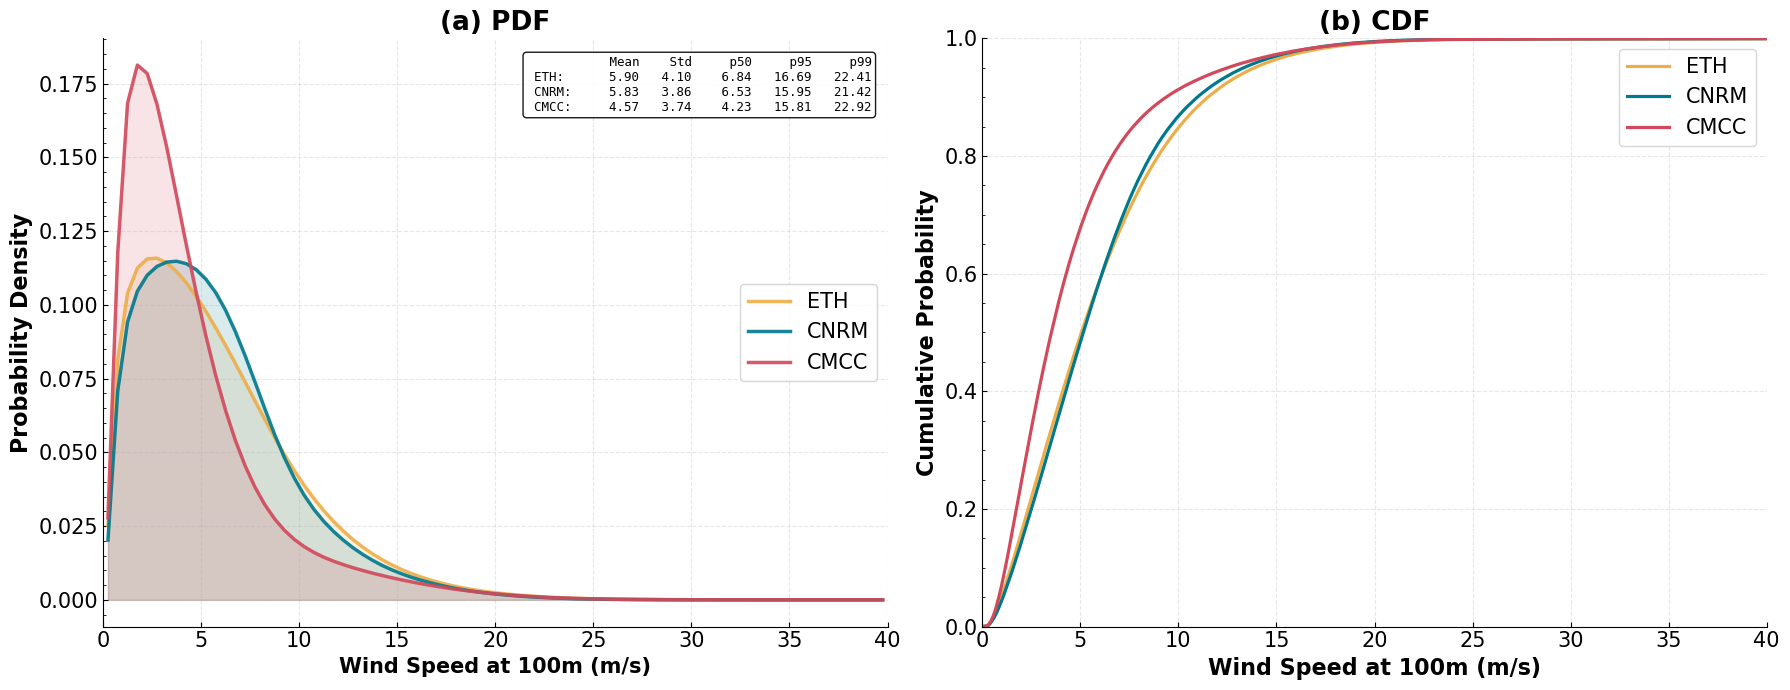

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))
# Plot PDF
ax1.plot(bin_centers, hist_eth, linewidth=2.5, color='#edae49', label='ETH', alpha=0.9)
ax1.plot(bin_centers, hist_cnrm, linewidth=2.5, color='#00798c', label='CNRM', alpha=0.9)
ax1.plot(bin_centers, hist_cmcc, linewidth=2.5, color='#d1495b', label='CMCC', alpha=0.9)
ax1.fill_between(bin_centers, hist_eth, alpha=0.15, color='#edae49')
ax1.fill_between(bin_centers, hist_cnrm, alpha=0.15, color='#00798c')
ax1.fill_between(bin_centers, hist_cmcc, alpha=0.15, color='#d1495b')
ax1.text(0.98, 0.97, stats_text, transform=ax1.transAxes, fontsize=9, verticalalignment='top', horizontalalignment='right',
         fontfamily='monospace', bbox=dict(boxstyle='round', facecolor='white', alpha=0.9))
ax1.set_xlabel('Wind Speed at 100m (m/s)', fontsize=15, fontweight='bold')
ax1.set_ylabel('Probability Density', fontsize=16, fontweight='bold')
ax1.set_title('(a) PDF', fontsize=19, fontweight='bold')
ax1.legend(fontsize=15)
ax1.grid(True, linestyle='--', alpha=0.3)
ax1.set_xlim(0, 40)

# Plot CDF
ax2.plot(quantiles_eth, cdf_values, linewidth=2.3, color='#edae49', label='ETH')
ax2.plot(quantiles_cnrm, cdf_values, linewidth=2.3, color='#00798c', label='CNRM')
ax2.plot(quantiles_cmcc, cdf_values, linewidth=2.3, color='#d1495b', label='CMCC')
ax2.set_xlabel('Wind Speed at 100m (m/s)', fontsize=16, fontweight='bold')
ax2.set_ylabel('Cumulative Probability', fontsize=16, fontweight='bold')
ax2.set_title('(b) CDF', fontsize=19, fontweight='bold')
ax2.legend(fontsize=15)
ax2.grid(True, linestyle='--', alpha=0.3)
ax2.set_xlim(0, 40)
ax2.set_ylim(0, 1)

for i, ax in enumerate([ax1, ax2]):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False) 
    ax.yaxis.set_minor_locator(AutoMinorLocator())
    ax.tick_params(which='both', direction='in', labelsize=15)
    

# plt.suptitle('Full Hourly Time Series Distributions (10 years)', fontsize=20, fontweight='bold')
plt.tight_layout()
plt.savefig(bd_out_fig+'PDF_CDF_FullTimeSeries.png', dpi=300, bbox_inches='tight', transparent=True)
plt.show()

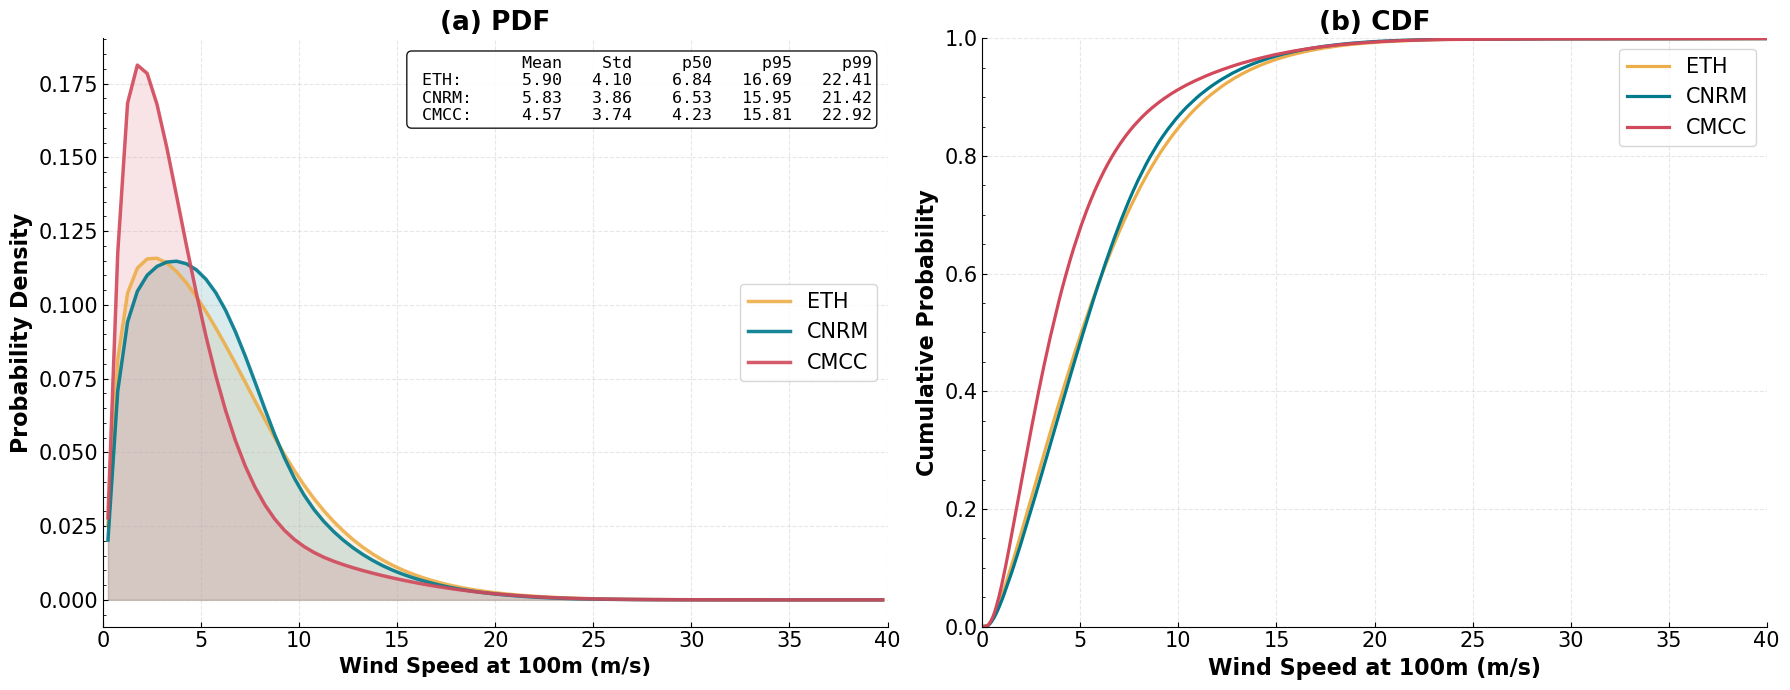

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))
# Plot PDF
ax1.plot(bin_centers, hist_eth, linewidth=2.5, color='#edae49', label='ETH', alpha=0.9)
ax1.plot(bin_centers, hist_cnrm, linewidth=2.5, color='#00798c', label='CNRM', alpha=0.9)
ax1.plot(bin_centers, hist_cmcc, linewidth=2.5, color='#d1495b', label='CMCC', alpha=0.9)
ax1.fill_between(bin_centers, hist_eth, alpha=0.15, color='#edae49')
ax1.fill_between(bin_centers, hist_cnrm, alpha=0.15, color='#00798c')
ax1.fill_between(bin_centers, hist_cmcc, alpha=0.15, color='#d1495b')
ax1.text(0.98, 0.97, stats_text, transform=ax1.transAxes, fontsize=12, verticalalignment='top', horizontalalignment='right',
         fontfamily='monospace', bbox=dict(boxstyle='round', facecolor='white', alpha=0.9))
ax1.set_xlabel('Wind Speed at 100m (m/s)', fontsize=15, fontweight='bold')
ax1.set_ylabel('Probability Density', fontsize=16, fontweight='bold')
ax1.set_title('(a) PDF', fontsize=19, fontweight='bold')
ax1.legend(fontsize=15)
ax1.grid(True, linestyle='--', alpha=0.3)
ax1.set_xlim(0, 40)

# Plot CDF
ax2.plot(quantiles_eth, cdf_values, linewidth=2.3, color='#edae49', label='ETH')
ax2.plot(quantiles_cnrm, cdf_values, linewidth=2.3, color='#00798c', label='CNRM')
ax2.plot(quantiles_cmcc, cdf_values, linewidth=2.3, color='#d1495b', label='CMCC')
ax2.set_xlabel('Wind Speed at 100m (m/s)', fontsize=16, fontweight='bold')
ax2.set_ylabel('Cumulative Probability', fontsize=16, fontweight='bold')
ax2.set_title('(b) CDF', fontsize=19, fontweight='bold')
ax2.legend(fontsize=15)
ax2.grid(True, linestyle='--', alpha=0.3)
ax2.set_xlim(0, 40)
ax2.set_ylim(0, 1)

for i, ax in enumerate([ax1, ax2]):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False) 
    ax.yaxis.set_minor_locator(AutoMinorLocator())
    ax.tick_params(which='both', direction='in', labelsize=15)
    
# plt.suptitle('Full Hourly Time Series Distributions (10 years)', fontsize=20, fontweight='bold')
plt.tight_layout()
plt.savefig(bd_out_fig+'PDF_CDF_FullTimeSeries.png', dpi=300, bbox_inches='tight', transparent=True)
plt.show()

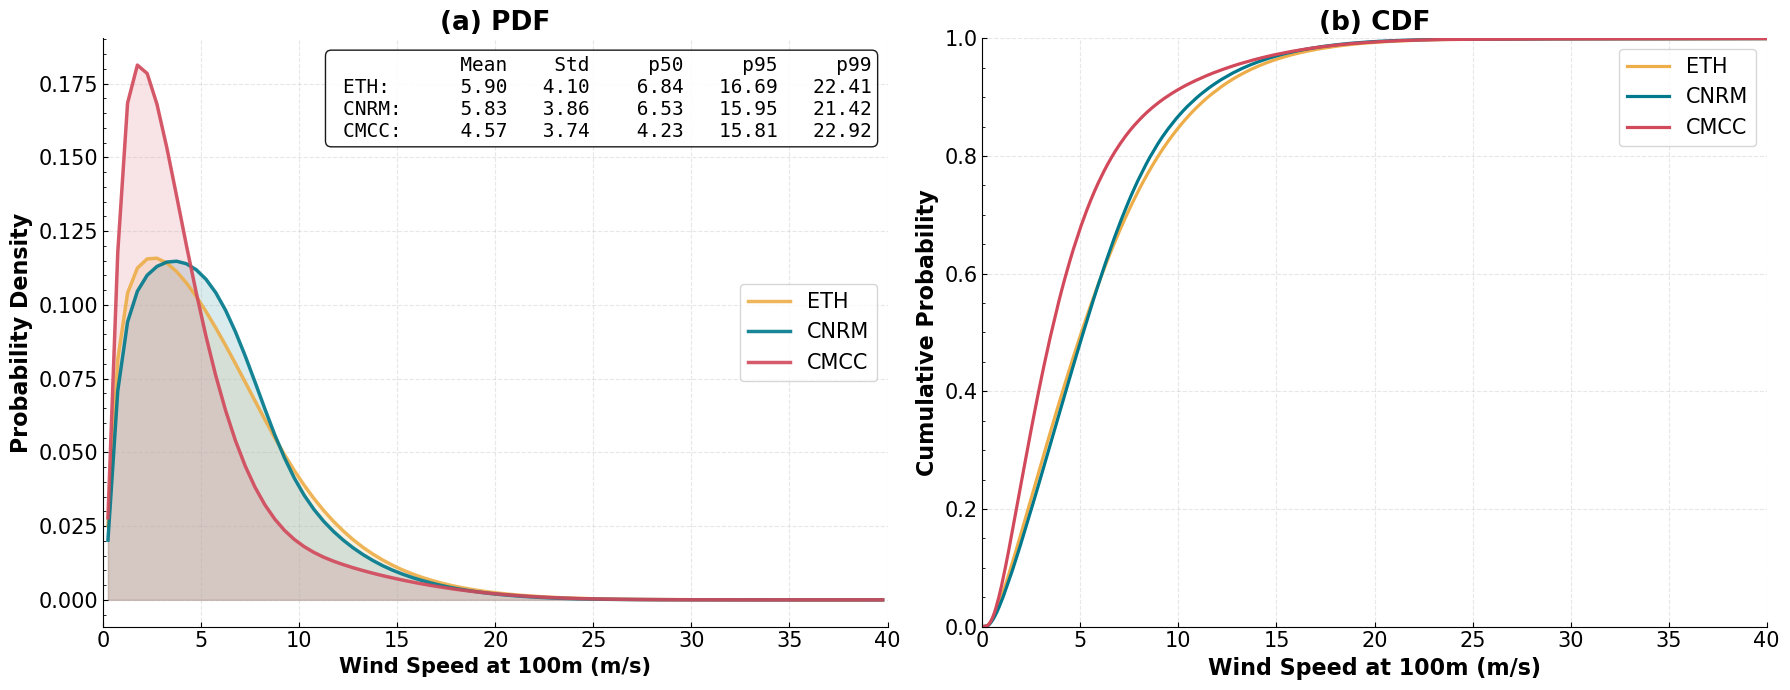

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))
# Plot PDF
ax1.plot(bin_centers, hist_eth, linewidth=2.5, color='#edae49', label='ETH', alpha=0.9)
ax1.plot(bin_centers, hist_cnrm, linewidth=2.5, color='#00798c', label='CNRM', alpha=0.9)
ax1.plot(bin_centers, hist_cmcc, linewidth=2.5, color='#d1495b', label='CMCC', alpha=0.9)
ax1.fill_between(bin_centers, hist_eth, alpha=0.15, color='#edae49')
ax1.fill_between(bin_centers, hist_cnrm, alpha=0.15, color='#00798c')
ax1.fill_between(bin_centers, hist_cmcc, alpha=0.15, color='#d1495b')
ax1.text(0.98, 0.97, stats_text, transform=ax1.transAxes, fontsize=14, verticalalignment='top', horizontalalignment='right',
         fontfamily='monospace', bbox=dict(boxstyle='round', facecolor='white', alpha=0.9))
ax1.set_xlabel('Wind Speed at 100m (m/s)', fontsize=15, fontweight='bold')
ax1.set_ylabel('Probability Density', fontsize=16, fontweight='bold')
ax1.set_title('(a) PDF', fontsize=19, fontweight='bold')
ax1.legend(fontsize=15)
ax1.grid(True, linestyle='--', alpha=0.3)
ax1.set_xlim(0, 40)

# Plot CDF
ax2.plot(quantiles_eth, cdf_values, linewidth=2.3, color='#edae49', label='ETH')
ax2.plot(quantiles_cnrm, cdf_values, linewidth=2.3, color='#00798c', label='CNRM')
ax2.plot(quantiles_cmcc, cdf_values, linewidth=2.3, color='#d1495b', label='CMCC')
ax2.set_xlabel('Wind Speed at 100m (m/s)', fontsize=16, fontweight='bold')
ax2.set_ylabel('Cumulative Probability', fontsize=16, fontweight='bold')
ax2.set_title('(b) CDF', fontsize=19, fontweight='bold')
ax2.legend(fontsize=15)
ax2.grid(True, linestyle='--', alpha=0.3)
ax2.set_xlim(0, 40)
ax2.set_ylim(0, 1)

for i, ax in enumerate([ax1, ax2]):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False) 
    ax.yaxis.set_minor_locator(AutoMinorLocator())
    ax.tick_params(which='both', direction='in', labelsize=15)
    
# plt.suptitle('Full Hourly Time Series Distributions (10 years)', fontsize=20, fontweight='bold')
plt.tight_layout()
plt.savefig(bd_out_fig+'PDF_CDF_FullTimeSeries.png', dpi=300, bbox_inches='tight', transparent=True)
plt.show()

No kernel connected